In [1]:
#https://www.kaggle.com/hidehisaarai1213/introduction-to-sound-event-detection v3

In [2]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695488000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12571888038994152347
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [3]:
#global consts
IMG_SIZE='orig'
HEIGHT = 137
WIDTH = 236
BATCH_SIZE=128
DROP_OUT=0.0
FOLD=0
TRAIN_DIR = './train/'
#TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 1
EXPERIMENT='birdcall_1draft'
INPUT_DIR ='/content/drive/My\ Drive/kaggle/birdcall/input/'
OUTPUT_DIR = '/content/drive/My\ Drive/kaggle/birdcall/output/'
IMPORT_DIR = '/content/drive/My\ Drive/kaggle/birdcall/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
GCS_BUCKET_MAIN =    'kds-98ea134097033de0df99848fe21626ee8a419f88ba6f08c98e00d930'
GCS_BUCKET_RESAMPLE0='kds-415a60f0bab644c1dede2edf10f91cfeaad783c1b318ff35aa8a6057'
GCS_BUCKET_RESAMPLE1='kds-cda6617a3763f98dd2f90fb05602099acdd36e44d8a6e6174f3bca95'
GCS_BUCKET_RESAMPLE2='kds-d82bf503ec8705865f629c692ba9810b10997d894e17c0cd7247fb8b'
GCS_BUCKET_RESAMPLE3='kds-b31ceb4bd3d930f079748ea02a1f6735046625e3dbb9c9c1249e2829'
GCS_BUCKET_RESAMPLE4='kds-1d9a31a537e9374856bb2a65d53b0b8e0639df9e11df6f0b1c24ceab'
GCS_BUCKET_CHECK=    'kds-0ebaf05ae13eb08d24ecc1e61d989ce4af8ef6aed6419926fed241e7'
GCS_BUCKET_WEIGHTS = 'kds-e9b9e6cfc6f8a1f16ec1c217b2be2e8ea229fef729aff904da453daa'

KDS=['birdsong-resampled-train-audio-00',
     'birdsong-resampled-train-audio-01',
     'birdsong-resampled-train-audio-02',
     'birdsong-resampled-train-audio-03',
     'birdsong-resampled-train-audio-04']


TRAIN_WITH_FOLD = 'train_with_fold.csv'
PRETRAINED = False
PRETRAINED_WEIGHTS = ''
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'

#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

#DATASET=DATASET_ORI


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [6]:
!pip install -q soundfile

In [7]:
!pip install -q -U catalyst

     |████████████████████████████████| 450kB 2.6MB/s 
     |████████████████████████████████| 317kB 11.8MB/s 
     |████████████████████████████████| 163kB 12.6MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 


In [8]:
import cv2
import audioread
import logging
import os
import errno
import random
import time
import warnings

import librosa
import librosa.display as display
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from contextlib import contextmanager
from IPython.display import Audio
from pathlib import Path
from typing import Optional, List

from catalyst.dl import SupervisedRunner, State, CallbackOrder, Callback, CheckpointCallback
from fastprogress import progress_bar
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score

In [9]:
!mkdir {EXPERIMENT_DIR}
!mkdir {CHKP_DIR}

mkdir: cannot create directory ‘/content/drive/My Drive/kaggle/birdcall/output/birdcall_1draft/’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/kaggle/birdcall/output/birdcall_1draft/chkp/’: File exists


In [10]:
from google.colab import auth
auth.authenticate_user()

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  25115      0 --:--:-- --:--:-- --:--:-- 25115
OK
57 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 57 not upgraded.
Need to get 4,278 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.30.0_amd64.deb ...
Unpacking gcsfuse (0.30.0) ...
Setting up gcsfuse (0.30.0) ...


In [11]:
!mkdir /content/gcs_data
!mkdir /content/gcs_data/gcs_main
!mkdir /content/gcs_data/gcs_check
!mkdir /content/gcs_data/gcs_r0
!mkdir /content/gcs_data/gcs_r1
!mkdir /content/gcs_data/gcs_r2
!mkdir /content/gcs_data/gcs_r3
!mkdir /content/gcs_data/gcs_r4
!mkdir /content/gcs_data/gcs_w

In [12]:
cd /content/gcs_data

/content/gcs_data


In [13]:
!gcsfuse --implicit-dirs {GCS_BUCKET_MAIN} gcs_main
!gcsfuse --implicit-dirs {GCS_BUCKET_CHECK} gcs_check
!gcsfuse --implicit-dirs {GCS_BUCKET_RESAMPLE0} gcs_r0
!gcsfuse --implicit-dirs {GCS_BUCKET_RESAMPLE1} gcs_r1
!gcsfuse --implicit-dirs {GCS_BUCKET_RESAMPLE2} gcs_r2
!gcsfuse --implicit-dirs {GCS_BUCKET_RESAMPLE3} gcs_r3
!gcsfuse --implicit-dirs {GCS_BUCKET_RESAMPLE4} gcs_r4
!gcsfuse --implicit-dirs {GCS_BUCKET_WEIGHTS} gcs_w

Using mount point: /content/gcs_data/gcs_main
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.
Using mount point: /content/gcs_data/gcs_check
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.
Using mount point: /content/gcs_data/gcs_r0
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.
Using mount point: /content/gcs_data/gcs_r1
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.
Using mount point: /content/gcs_data/gcs_r2
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.
Using mount point: /content/gcs_data/gcs_r3
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.
Using mount point: /content/gcs_data/gcs_r4
Opening GCS connectio

In [14]:
LOCAL_DATA='/content/local_data/'

In [15]:
!mkdir {LOCAL_DATA}

In [16]:
cd /content/local_data

/content/local_data


In [17]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andreyzotov","key":"afe3694f0d1ce87518f232c8a5c9a0b5"}'}

In [18]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
# we need to set permissions 
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [19]:
import zipfile
from tqdm import tqdm

for i,kaggle_ds in enumerate(KDS):
  !kaggle datasets download -d ttahara/{kaggle_ds}
  !mkdir r{i}
  zip_f = kaggle_ds+'.zip'
  with zipfile.ZipFile(zip_f) as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
      try:
        zf.extract(member, f'r{i}')
      except zipfile.error as e:
        pass
  !rm {zip_f}

100% 11.7G/11.7G [04:25<00:00, 66.0MB/s]
100% 11.7G/11.7G [04:25<00:00, 47.6MB/s]


Extracting : 100%|██████████| 4525/4525 [06:01<00:00, 12.52it/s]


100% 9.24G/9.25G [03:06<00:00, 43.5MB/s]
100% 9.25G/9.25G [03:06<00:00, 53.3MB/s]


Extracting : 100%|██████████| 3929/3929 [04:43<00:00, 13.84it/s]


100% 11.2G/11.2G [04:15<00:00, 57.8MB/s]
100% 11.2G/11.2G [04:15<00:00, 47.2MB/s]


Extracting : 100%|██████████| 4713/4713 [05:43<00:00, 13.71it/s]


100% 8.88G/8.89G [03:39<00:00, 51.9MB/s]
100% 8.89G/8.89G [03:39<00:00, 43.5MB/s]


Extracting : 100%|██████████| 3819/3819 [04:31<00:00, 14.04it/s]


100% 11.0G/11.0G [03:48<00:00, 32.0MB/s]
100% 11.0G/11.0G [03:48<00:00, 51.5MB/s]


Extracting : 100%|██████████| 4394/4394 [05:38<00:00, 12.98it/s]


In [20]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
    
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger
    
    
@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    
    
set_seed(202020)

In [21]:
ls /content/gcs_data/

gcs_check/  gcs_main/  gcs_r0/  gcs_r1/  gcs_r2/  gcs_r3/  gcs_r4/  gcs_w/


In [22]:
ls /content/local_data/

kaggle.json  r0/  r1/  r2/  r3/  r4/


In [23]:
Path.cwd().parent

PosixPath('/content')

In [24]:
ROOT = Path.cwd().parent
INPUT_ROOT = ROOT/"gcs_data"
RAW_DATA = INPUT_ROOT/"gcs_main"
TRAIN_AUDIO_DIR = RAW_DATA/"train_audio"
TRAIN_RESAMPLED_AUDIO_DIRS = [
 ROOT/"local_data"/"r{:0>1}".format(i)  for i in range(5)
]
TEST_AUDIO_DIR = RAW_DATA/"test_audio"

In [25]:
TRAIN_RESAMPLED_AUDIO_DIRS

[PosixPath('/content/local_data/r0'),
 PosixPath('/content/local_data/r1'),
 PosixPath('/content/local_data/r2'),
 PosixPath('/content/local_data/r3'),
 PosixPath('/content/local_data/r4')]

In [26]:
train = pd.read_csv(TRAIN_RESAMPLED_AUDIO_DIRS[0]/"train_mod.csv")

if not TEST_AUDIO_DIR.exists():
    TEST_AUDIO_DIR = INPUT_ROOT/"gcs_check"/"test_audio"
    test = pd.read_csv(INPUT_ROOT/"gcs_check"/"test.csv")
else:
    test = pd.read_csv(RAW_DATA/"test.csv")

In [29]:
class DFTBase(nn.Module):
    def __init__(self):
        """Base class for DFT and IDFT matrix"""
        super(DFTBase, self).__init__()

    def dft_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(-2 * np.pi * 1j / n)
        W = np.power(omega, x * y)
        return W

    def idft_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(2 * np.pi * 1j / n)
        W = np.power(omega, x * y)
        return W
    
    
class STFT(DFTBase):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, 
        window='hann', center=True, pad_mode='reflect', freeze_parameters=True):
        """Implementation of STFT with Conv1d. The function has the same output 
        of librosa.core.stft
        """
        super(STFT, self).__init__()

        assert pad_mode in ['constant', 'reflect']

        self.n_fft = n_fft
        self.center = center
        self.pad_mode = pad_mode

        # By default, use the entire frame
        if win_length is None:
            win_length = n_fft

        # Set the default hop, if it's not already specified
        if hop_length is None:
            hop_length = int(win_length // 4)

        fft_window = librosa.filters.get_window(window, win_length, fftbins=True)

        # Pad the window out to n_fft size
        fft_window = librosa.util.pad_center(fft_window, n_fft)

        # DFT & IDFT matrix
        self.W = self.dft_matrix(n_fft)

        out_channels = n_fft // 2 + 1

        self.conv_real = nn.Conv1d(in_channels=1, out_channels=out_channels, 
            kernel_size=n_fft, stride=hop_length, padding=0, dilation=1, 
            groups=1, bias=False)

        self.conv_imag = nn.Conv1d(in_channels=1, out_channels=out_channels, 
            kernel_size=n_fft, stride=hop_length, padding=0, dilation=1, 
            groups=1, bias=False)

        self.conv_real.weight.data = torch.Tensor(
            np.real(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        self.conv_imag.weight.data = torch.Tensor(
            np.imag(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        """input: (batch_size, data_length)
        Returns:
          real: (batch_size, n_fft // 2 + 1, time_steps)
          imag: (batch_size, n_fft // 2 + 1, time_steps)
        """

        x = input[:, None, :]   # (batch_size, channels_num, data_length)

        if self.center:
            x = F.pad(x, pad=(self.n_fft // 2, self.n_fft // 2), mode=self.pad_mode)

        real = self.conv_real(x)
        imag = self.conv_imag(x)
        # (batch_size, n_fft // 2 + 1, time_steps)

        real = real[:, None, :, :].transpose(2, 3)
        imag = imag[:, None, :, :].transpose(2, 3)
        # (batch_size, 1, time_steps, n_fft // 2 + 1)

        return real, imag
    
    
class Spectrogram(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, 
        window='hann', center=True, pad_mode='reflect', power=2.0, 
        freeze_parameters=True):
        """Calculate spectrogram using pytorch. The STFT is implemented with 
        Conv1d. The function has the same output of librosa.core.stft
        """
        super(Spectrogram, self).__init__()

        self.power = power

        self.stft = STFT(n_fft=n_fft, hop_length=hop_length, 
            win_length=win_length, window=window, center=center, 
            pad_mode=pad_mode, freeze_parameters=True)

    def forward(self, input):
        """input: (batch_size, 1, time_steps, n_fft // 2 + 1)
        Returns:
          spectrogram: (batch_size, 1, time_steps, n_fft // 2 + 1)
        """

        (real, imag) = self.stft.forward(input)
        # (batch_size, n_fft // 2 + 1, time_steps)

        spectrogram = real ** 2 + imag ** 2

        if self.power == 2.0:
            pass
        else:
            spectrogram = spectrogram ** (power / 2.0)

        return spectrogram

    
class LogmelFilterBank(nn.Module):
    def __init__(self, sr=32000, n_fft=2048, n_mels=64, fmin=50, fmax=14000, is_log=True, 
        ref=1.0, amin=1e-10, top_db=80.0, freeze_parameters=True):
        """Calculate logmel spectrogram using pytorch. The mel filter bank is 
        the pytorch implementation of as librosa.filters.mel 
        """
        super(LogmelFilterBank, self).__init__()

        self.is_log = is_log
        self.ref = ref
        self.amin = amin
        self.top_db = top_db

        self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,
            fmin=fmin, fmax=fmax).T
        # (n_fft // 2 + 1, mel_bins)

        self.melW = nn.Parameter(torch.Tensor(self.melW))

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        """input: (batch_size, channels, time_steps)
        
        Output: (batch_size, time_steps, mel_bins)
        """

        # Mel spectrogram
        mel_spectrogram = torch.matmul(input, self.melW)

        # Logmel spectrogram
        if self.is_log:
            output = self.power_to_db(mel_spectrogram)
        else:
            output = mel_spectrogram

        return output


    def power_to_db(self, input):
        """Power to db, this function is the pytorch implementation of 
        librosa.core.power_to_lb
        """
        ref_value = self.ref
        log_spec = 10.0 * torch.log10(torch.clamp(input, min=self.amin, max=np.inf))
        log_spec -= 10.0 * np.log10(np.maximum(self.amin, ref_value))

        if self.top_db is not None:
            if self.top_db < 0:
                raise ParameterError('top_db must be non-negative')
            log_spec = torch.clamp(log_spec, min=log_spec.max().item() - self.top_db, max=np.inf)

        return log_spec

In [30]:
class DropStripes(nn.Module):
    def __init__(self, dim, drop_width, stripes_num):
        """Drop stripes. 
        Args:
          dim: int, dimension along which to drop
          drop_width: int, maximum width of stripes to drop
          stripes_num: int, how many stripes to drop
        """
        super(DropStripes, self).__init__()

        assert dim in [2, 3]    # dim 2: time; dim 3: frequency

        self.dim = dim
        self.drop_width = drop_width
        self.stripes_num = stripes_num

    def forward(self, input):
        """input: (batch_size, channels, time_steps, freq_bins)"""

        assert input.ndimension() == 4

        if self.training is False:
            return input

        else:
            batch_size = input.shape[0]
            total_width = input.shape[self.dim]

            for n in range(batch_size):
                self.transform_slice(input[n], total_width)

            return input


    def transform_slice(self, e, total_width):
        """e: (channels, time_steps, freq_bins)"""

        for _ in range(self.stripes_num):
            distance = torch.randint(low=0, high=self.drop_width, size=(1,))[0]
            bgn = torch.randint(low=0, high=total_width - distance, size=(1,))[0]

            if self.dim == 2:
                e[:, bgn : bgn + distance, :] = 0
            elif self.dim == 3:
                e[:, :, bgn : bgn + distance] = 0


class SpecAugmentation(nn.Module):
    def __init__(self, time_drop_width, time_stripes_num, freq_drop_width, 
        freq_stripes_num):
        """Spec augmetation. 
        [ref] Park, D.S., Chan, W., Zhang, Y., Chiu, C.C., Zoph, B., Cubuk, E.D. 
        and Le, Q.V., 2019. Specaugment: A simple data augmentation method 
        for automatic speech recognition. arXiv preprint arXiv:1904.08779.
        Args:
          time_drop_width: int
          time_stripes_num: int
          freq_drop_width: int
          freq_stripes_num: int
        """

        super(SpecAugmentation, self).__init__()

        self.time_dropper = DropStripes(dim=2, drop_width=time_drop_width, 
            stripes_num=time_stripes_num)

        self.freq_dropper = DropStripes(dim=3, drop_width=freq_drop_width, 
            stripes_num=freq_stripes_num)

    def forward(self, input):
        x = self.time_dropper(input)
        x = self.freq_dropper(x)
        return x

In [31]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.

    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()

    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):

        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [32]:
class PANNsCNN14Att(nn.Module):
    def __init__(self, sample_rate: int, window_size: int, hop_size: int,
                 mel_bins: int, fmin: int, fmax: int, classes_num: int):
        super().__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 32  # Downsampled ratio

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(
            sr=sample_rate,
            n_fft=window_size,
            n_mels=mel_bins,
            fmin=fmin,
            fmax=fmax,
            ref=ref,
            amin=amin,
            top_db=top_db,
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(
            time_drop_width=64,
            time_stripes_num=2,
            freq_drop_width=8,
            freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(mel_bins)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
        self.att_block = AttBlock(2048, classes_num, activation='sigmoid')

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        
    def cnn_feature_extractor(self, x):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        return x
    
    def preprocess(self, input, mixup_lambda=None):
        # t1 = time.time()
        x = self.spectrogram_extractor(input)  # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)  # (batch_size, 1, time_steps, mel_bins)

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        return x, frames_num
        

    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""
        x, frames_num = self.preprocess(input, mixup_lambda=mixup_lambda)

        # Output shape (batch size, channels, time, frequency)
        x = self.cnn_feature_extractor(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=3)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        output_dict = {
            'framewise_output': framewise_output,
            'clipwise_output': clipwise_output
        }

        return output_dict

In [33]:
SR = 32000

y, _ = librosa.load(TRAIN_RESAMPLED_AUDIO_DIRS[0] / "aldfly" / "XC134874.wav",
                    sr=SR,
                    res_type="kaiser_fast",
                    mono=True)

Audio(y, rate=SR)

Output hidden; open in https://colab.research.google.com to view.

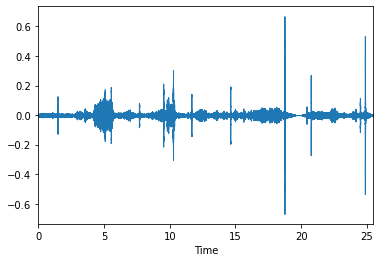

In [34]:
display.waveplot(y, sr=SR);

In [35]:
model_config = {
    "sample_rate": 32000,
    "window_size": 1024,
    "hop_size": 320,
    "mel_bins": 64,
    "fmin": 50,
    "fmax": 14000,
    "classes_num": 264
}

model = PANNsCNN14Att(**model_config)

In [36]:
chunk = torch.from_numpy(y[:SR * 5]).unsqueeze(0)
melspec, _ = model.preprocess(chunk)
melspec.size()

torch.Size([1, 1, 501, 64])

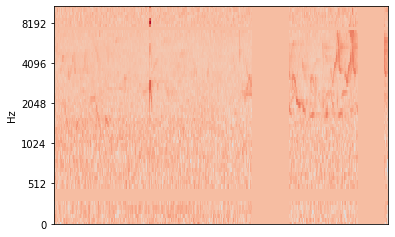

In [37]:
melspec_numpy = melspec.detach().numpy()[0, 0].transpose(1, 0)
display.specshow(melspec_numpy, sr=SR, y_axis="mel");

In [38]:
feature_map = model.cnn_feature_extractor(melspec)
feature_map.size()

torch.Size([1, 2048, 15, 2])

In [39]:
BIRD_CODE = {
    'aldfly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

INV_BIRD_CODE = {v: k for k, v in BIRD_CODE.items()}

In [40]:
PERIOD = 5

class PANNsDataset(data.Dataset):
    def __init__(
            self,
            file_list: List[List[str]],
            waveform_transforms=None):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.waveform_transforms = waveform_transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return {"waveform": y, "targets": labels}

In [41]:
class PANNsLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.bce = nn.BCELoss()

    def forward(self, input, target):
        input_ = input["clipwise_output"]
        input_ = torch.where(torch.isnan(input_),
                             torch.zeros_like(input_),
                             input_)
        input_ = torch.where(torch.isinf(input_),
                             torch.zeros_like(input_),
                             input_)

        target = target.float()

        return self.bce(input_, target)

In [42]:
class F1Callback(Callback):
    def __init__(self,
                 input_key: str = "targets",
                 output_key: str = "logits",
                 model_output_key: str = "clipwise_output",
                 prefix: str = "f1"):
        super().__init__(CallbackOrder.Metric)

        self.input_key = input_key
        self.output_key = output_key
        self.model_output_key = model_output_key
        self.prefix = prefix

    def on_loader_start(self, state: State):
        self.prediction: List[np.ndarray] = []
        self.target: List[np.ndarray] = []

    def on_batch_end(self, state: State):
        targ = state.input[self.input_key].detach().cpu().numpy()
        out = state.output[self.output_key]

        clipwise_output = out[self.model_output_key].detach().cpu().numpy()

        self.prediction.append(clipwise_output)
        self.target.append(targ)

        y_pred = clipwise_output.argmax(axis=1)
        y_true = targ.argmax(axis=1)

        score = f1_score(y_true, y_pred, average="macro")
        state.batch_metrics[self.prefix] = score

    def on_loader_end(self, state: State):
        y_pred = np.concatenate(self.prediction, axis=0).argmax(axis=1)
        y_true = np.concatenate(self.target, axis=0).argmax(axis=1)
        score = f1_score(y_true, y_pred, average="macro")
        state.loader_metrics[self.prefix] = score
        if state.is_valid_loader:
            state.epoch_metrics[state.valid_loader + "_epoch_" +
                                self.prefix] = score
        else:
            state.epoch_metrics["train_epoch_" + self.prefix] = score


class mAPCallback(Callback):
    def __init__(self,
                 input_key: str = "targets",
                 output_key: str = "logits",
                 model_output_key: str = "clipwise_output",
                 prefix: str = "mAP"):
        super().__init__(CallbackOrder.Metric)
        self.input_key = input_key
        self.output_key = output_key
        self.model_output_key = model_output_key
        self.prefix = prefix

    def on_loader_start(self, state: State):
        self.prediction: List[np.ndarray] = []
        self.target: List[np.ndarray] = []

    def on_batch_end(self, state: State):
        targ = state.input[self.input_key].detach().cpu().numpy()
        out = state.output[self.output_key]

        clipwise_output = out[self.model_output_key].detach().cpu().numpy()

        self.prediction.append(clipwise_output)
        self.target.append(targ)

        score = average_precision_score(targ, clipwise_output, average=None)
        score = np.nan_to_num(score).mean()
        state.batch_metrics[self.prefix] = score

    def on_loader_end(self, state: State):
        y_pred = np.concatenate(self.prediction, axis=0)
        y_true = np.concatenate(self.target, axis=0)
        score = average_precision_score(y_true, y_pred, average=None)
        score = np.nan_to_num(score).mean()
        state.loader_metrics[self.prefix] = score
        if state.is_valid_loader:
            state.epoch_metrics[state.valid_loader + "_epoch_" +
                                self.prefix] = score
        else:
            state.epoch_metrics["train_epoch_" + self.prefix] = score

In [43]:
tmp_list = []
for audio_d in TRAIN_RESAMPLED_AUDIO_DIRS:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for wav_f in ebird_d.iterdir():
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id
    
# # check the propotion
fold_proportion = pd.pivot_table(train_all, index="ebird_code", columns="fold", values="xc_id", aggfunc=len)
print(fold_proportion.shape)

(264, 5)


In [45]:
use_fold = 0
train_file_list = train_all.query("fold != @use_fold")[["file_path", "ebird_code"]].values.tolist()
val_file_list = train_all.query("fold == @use_fold")[["file_path", "ebird_code"]].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(val_file_list)))

[fold 0] train: 17100, val: 4275


In [46]:
device = torch.device("cuda:0")

In [68]:
# loaders
loaders = {
    "train": data.DataLoader(PANNsDataset(train_file_list, None), 
                             batch_size=64, 
                             shuffle=True, 
                             num_workers=2, 
                             pin_memory=True, 
                             drop_last=True),
    "valid": data.DataLoader(PANNsDataset(val_file_list, None), 
                             batch_size=64, 
                             shuffle=False,
                             num_workers=2,
                             pin_memory=True,
                             drop_last=False)
}

# model
model_config["classes_num"] = 527
model = PANNsCNN14Att(**model_config)
weights = torch.load("/content/gcs_data/gcs_w/Cnn14_DecisionLevelAtt_mAP0.425.pth")
# Fixed in V3
model.load_state_dict(weights["model"])
model.att_block = AttBlock(2048, 264, activation='sigmoid')
model.att_block.init_weights()
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Loss
criterion = PANNsLoss().to(device)

In [51]:
# callbacks
callbacks = [
    F1Callback(input_key="targets", output_key="logits", prefix="f1"),
    mAPCallback(input_key="targets", output_key="logits", prefix="mAP"),
    CheckpointCallback(save_n_best=0)
]

In [ ]:
warnings.simplefilter("ignore")

runner = SupervisedRunner(
    device=device,
    input_key="waveform",
    input_target_key="targets")

runner.train(
    model=model,
    criterion=criterion,
    loaders=loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    verbose=False,
    logdir='/content/drive/My Drive/kaggle/birdcall/output/birdcall_1draft/fold0',
    callbacks=callbacks,
    main_metric="epoch_f1",
    minimize_metric=False)

[2020-08-28 23:13:28,563] 
1/30 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/30 * Epoch 1 (train): epoch_f1=0.1746 | epoch_mAP=0.1396 | f1=0.1273 | loss=0.0191 | mAP=0.1044
1/30 * Epoch 1 (valid): epoch_f1=0.1838 | epoch_mAP=0.2343 | f1=0.0374 | loss=0.0215 | mAP=0.0139
[2020-08-28 23:13:28,563] 
1/30 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/30 * Epoch 1 (train): epoch_f1=0.1746 | epoch_mAP=0.1396 | f1=0.1273 | loss=0.0191 | mAP=0.1044
1/30 * Epoch 1 (valid): epoch_f1=0.1838 | epoch_mAP=0.2343 | f1=0.0374 | loss=0.0215 | mAP=0.0139
[2020-08-28 23:13:28,563] 
1/30 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/30 * Epoch 1 (train): epoch_f1=0.1746 | epoch_mAP=0.1396 | f1=0.1273 | loss=0.0191 | mAP=0.1044
1/30 * Epoch 1 (valid): epoch_f1=0.1838 | epoch_mAP=0.2343 | f1=0.0374 | loss=0.0215 | mAP=0.0139
[2020-08-28 23:13:28,563] 
1/30 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/30 * Epoch 1 (train): epoch_f1=0.1746 | epoch_mAP=0.1396 | f1=0.1273 | loss=0.0191 | mAP=0.104